In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from google.colab import files
from io import BytesIO
from PIL import Image
import tensorflow as tf
from keras.applications import vgg19

In [2]:
upl=files.upload()
names=list(upl.keys())
img=Image.open(BytesIO(upl[names[0]]))
img=img.resize((224,224),Image.ANTIALIAS)
img.save(names[0])

img_style=Image.open(BytesIO(upl[names[1]]))
img_style=img_style.resize((224,224),Image.ANTIALIAS)
img_style.save(names[1])

Saving 1a8704a38498e095bcde4e50fe00547f.jpg to 1a8704a38498e095bcde4e50fe00547f.jpg
Saving 3305b554f290927fda17438ea817a76a.jpg to 3305b554f290927fda17438ea817a76a.jpg


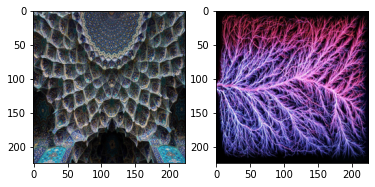

In [3]:
plt.subplot(1, 2, 1)
plt.imshow( img )
plt.subplot(1, 2, 2)
plt.imshow( img_style )
plt.show()

In [4]:
x_img=vgg19.preprocess_input(np.expand_dims(img,axis=0))
print(x_img.shape)
x_style=vgg19.preprocess_input(np.expand_dims(img_style,axis=0))

(1, 224, 224, 3)


In [ ]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [ ]:
content_layers=['block5_conv2',]

style_layers=['block1_conv1',
              'block2_conv1',
              'block3_conv1',
              'block4_conv1',
              'block5_conv1',   
]
num_content_layers=len(content_layers)
num_style_layers=len(style_layers)

In [ ]:
vgg=keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
vgg.trainable=False

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
style_outputs=[vgg.get_layer(name).output for name in style_layers]
content_outputs=[vgg.get_layer(name).output for name in content_layers]
model_outputs=style_outputs+content_outputs

print(vgg.input)
for m in model_outputs:
  print(m)

model=keras.models.Model(vgg.input,model_outputs)
print(model.summary())

KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name=None), name='block1_conv1/Relu:0', description="created by layer 'block1_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 128), dtype=tf.float32, name=None), name='block2_conv1/Relu:0', description="created by layer 'block2_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 256), dtype=tf.float32, name=None), name='block3_conv1/Relu:0', description="created by layer 'block3_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block4_conv1/Relu:0', description="created by layer 'block4_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block5_conv1/Relu:0', description="created by layer 'block5_conv1'")
K

In [ ]:
def get_feature_representations(model):

  style_outputs = model(x_style)
  content_outputs = model(x_img)
  

  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

def get_content_loss(base_content,target):
  return tf.reduce_mean(tf.square(base_content-target))

In [ ]:
def gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

In [ ]:
def get_style_loss(base_style, gram_target):
  gram_style = gram_matrix(base_style)
  return tf.reduce_mean(tf.square(gram_style - gram_target))

In [ ]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  style_weight, content_weight = loss_weights
  
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  loss = style_score + content_score 
  return loss, style_score, content_score

In [ ]:
num_iterations=110
content_weight=1e3
style_weight=1e-2

style_features, content_features = get_feature_representations(model)
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

init_image = np.copy(x_img)
init_image = tf.Variable(init_image, dtype=tf.float32)

opt = tf.compat.v1.train.AdamOptimizer(learning_rate=2, beta1=0.99, epsilon=1e-1)
iter_count = 1
best_loss, best_img = float('inf'), None
loss_weights = (style_weight, content_weight)

cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
}

norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means
imgs = []

for i in range(num_iterations):
    with tf.GradientTape() as tape: 
       all_loss = compute_loss(**cfg)
    
    loss, style_score, content_score = all_loss
    grads = tape.gradient(loss, init_image)

    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

      # Use the .numpy() method to get the concrete numpy array
      plot_img = deprocess_img(init_image.numpy())
      imgs.append(plot_img)
      print('Iteration: {}'.format(i))



ValueError: ignored

tf.Tensor(26458558.0, shape=(), dtype=float32)


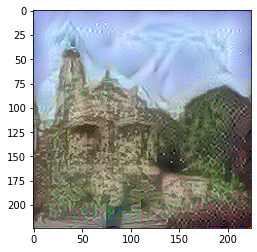

In [ ]:
plt.imshow(best_img)
print(best_loss)

In [ ]:
image = Image.fromarray(best_img.astype('uint8'), 'RGB')
image.save("result.jpg")
files.download("result.jpg")